In [281]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [282]:
import numpy as np
import pandas as pd
from scipy import stats

In [283]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [284]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [285]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [286]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [287]:
# We can view all of the classes that automap found
Base.classes.keys()


[&#39;measurement&#39;, &#39;station&#39;]

In [288]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [289]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

The last date is : 2017-08-23
The date 1 year ago from the last date is : 2016-08-23


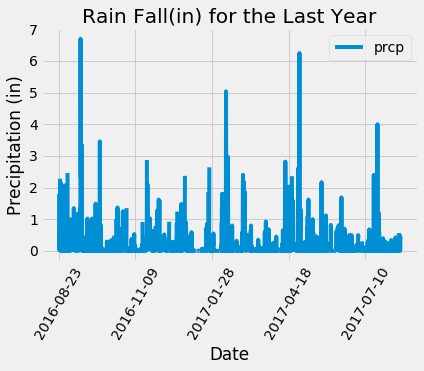

In [290]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print("The last date is :", last_date)

# Calculate the date 1 year ago from the last data point in the database
first_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print("The date 1 year ago from the last date is :", first_date)

# Perform a query to retrieve the data and precipitation scores
data_precp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= first_date).all()
#data_precp

# Save the query results as a Pandas DataFrame and set the index to the date column
data_precp_df = pd.DataFrame(data_precp, columns = ["date", "prcp"])
data_precp_df.set_index(data_precp_df["date"], inplace=True)
data_precp_df = data_precp_df[['prcp']]

# Sort the dataframe by date
data_precp_df = data_precp_df.sort_index()
#print(data_precp_df.head(50))

# Use Pandas Plotting with Matplotlib to plot the data
data_precp_df.plot(rot=60)
plt.xlabel('Date')
plt.ylabel('Precipitation (in)')
plt.title('Rain Fall(in) for the Last Year')
plt.savefig("Images output/Rain_Fall_last_year.png",bbox_inches='tight')
plt.show()


In [291]:
# Use Pandas to calculate the summary statistics for the precipitation data
statistics = data_precp_df["prcp"].describe()
statistics_df = pd.DataFrame(statistics)
statistics_df.rename(columns = {"prcp": "precipitation"})


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [292]:
# Design a query to show how many stations are available in this dataset?
station = session.query(Station).group_by(Station.station).count()
print(f'There are {station} stations available')


There are 9 stations available


In [293]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()


[(&#39;USC00519281&#39;, 2772),
 (&#39;USC00519397&#39;, 2724),
 (&#39;USC00513117&#39;, 2709),
 (&#39;USC00519523&#39;, 2669),
 (&#39;USC00516128&#39;, 2612),
 (&#39;USC00514830&#39;, 2202),
 (&#39;USC00511918&#39;, 1979),
 (&#39;USC00517948&#39;, 1372),
 (&#39;USC00518838&#39;, 511)]

In [294]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station,func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
        group_by(Measurement.station).all()


[(&#39;USC00519281&#39;, 54.0, 85.0, 71.66378066378067)]

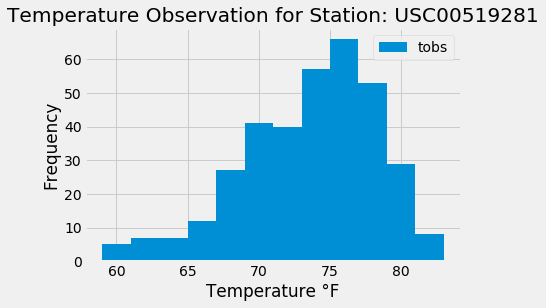

In [295]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
        filter(func.strftime('%Y-%m-%d', Measurement.date) >= first_date).all()

# Create the dataframe
highest_temp_df = pd.DataFrame(highest_temp, columns=['date','tobs'])
highest_temp_df.set_index('date', inplace=True)

# Plot the results as a histogram
plt.hist(highest_temp_df["tobs"], bins=12)
plt.xlabel('Temperature °F')
plt.ylabel("Frequency")
plt.legend(["tobs"])
plt.title(f'Temperature Observation for Station: USC00519281')

# Save the plot
plt.savefig("Images output/Temperature_Observation.png",bbox_inches='tight')
plt.show()


## Bonus Challenge Assignment

## Temperature Analysis I

In [306]:
# Hawaii is reputed to enjoy mild weather all year. 
#Is there a meaningful difference between the temperature in, for example, June and December?

# Identify the average temperature in June at all stations across all available years in the dataset.

# For June Temperatura
june = "06"

june_avg = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date) == june).all()
june_avg


[(74.13939393939394),
 (74.05084745762711),
 (76.00537634408602),
 (71.9372197309417),
 (76.6554054054054),
 (73.39473684210526),
 (73.27118644067797),
 (77.55932203389831),
 (76.66810344827586)]

In [317]:
# For December Temperature
dec = "12"

dec_avg = session.query(func.avg(Measurement.tobs)).group_by(Measurement.station).\
    filter(func.strftime("%m", Measurement.date) == dec ).all()
dec_avg

[(69.6842105263158),
 (71.06944444444444),
 (73.2247191011236),
 (69.29126213592232),
 (71.8348623853211),
 (72.42105263157895),
 (69.90322580645162),
 (71.10952380952381),
 (72.43333333333334)]

In [346]:
# Use the t-test to determine whether the difference in the means, if any, is statistically significant.

stats.ttest_ind(june_avg, dec_avg, equal_var = False)

Ttest_indResult(statistic=array([4.61586542]), pvalue=array([0.00036573]))

###  p value is smaller then 0.05 our data is valid and there is no significant difference between June and December tempratures.

## Temperature Analysis II

In [338]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [339]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage 
temperature = calc_temps('2016-12-30', '2017-01-14')
temperature

[(60.0, 68.5, 81.0)]

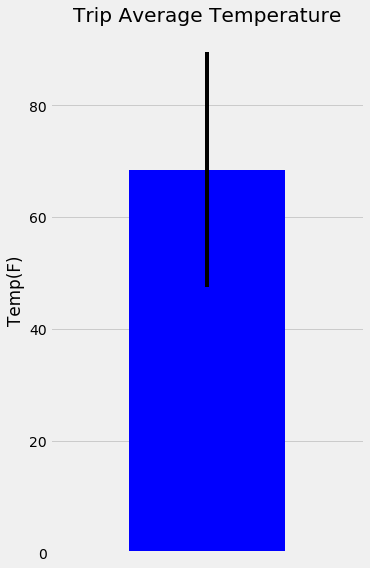

In [340]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

#Create the dataframe
df = pd.DataFrame(temperature, columns=["t_min", "t_avg", "t_max"])
df

# plot the average temp 
plt.figure(figsize=(5,9))
ax=df["t_avg"].plot.bar(yerr=(df["t_max"]-df["t_min"]), color="blue")
plt.title("Trip Average Temperature")
plt.ylabel("Temp(F)")
ax.axes.get_xaxis().set_visible(False)

# Save the plot
plt.savefig("Images output/avg_temp.png",bbox_inches='tight')
plt.show()

## Daily Rainfall Average

In [341]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-12-30'
end_date = '2017-01-14'
tot = [func.count(Measurement.prcp),Measurement.station, Station.name, Station.latitude, Station.longitude,Station.elevation]
rainfall=session.query(*tot).filter(Measurement.station==Station.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).\
    order_by(func.count(Measurement.prcp).desc()).all()
for r in rainfall:
    print(r)
 

(16, &#39;USC00519397&#39;, &#39;WAIKIKI 717.2, HI US&#39;, 21.2716, -157.8168, 3.0)
(16, &#39;USC00519281&#39;, &#39;WAIHEE 837.5, HI US&#39;, 21.45167, -157.84888999999998, 32.9)
(16, &#39;USC00516128&#39;, &#39;MANOA LYON ARBO 785.2, HI US&#39;, 21.3331, -157.8025, 152.4)
(16, &#39;USC00513117&#39;, &#39;KANEOHE 838.1, HI US&#39;, 21.4234, -157.8015, 14.6)
(14, &#39;USC00514830&#39;, &#39;KUALOA RANCH HEADQUARTERS 886.9, HI US&#39;, 21.5213, -157.8374, 7.0)
(8, &#39;USC00519523&#39;, &#39;WAIMANALO EXPERIMENTAL FARM, HI US&#39;, 21.33556, -157.71139, 19.5)
(0, &#39;USC00517948&#39;, &#39;PEARL CITY, HI US&#39;, 21.3934, -157.9751, 11.9)


In [342]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [343]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = '2016-12-30'
end_date = '2017-01-14'

# Use the start and end date to create a range of dates
range_dates = pd.date_range(start_date, end_date)

# Stip off the year and save a list of %m-%d strings
trip = range_dates.strftime('%m-%d')


# Loop through the list of %m-%d strings and calculate the normals for each date
for range_dates in trip:
    normals.append(*daily_normals(range_dates))


In [344]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['Tmin', 'Tavg', 'Tmax'])
normals_df['Date'] = trip
normals_df = normals_df.set_index('Date')
normals_df


,Tmin,Tavg,Tmax
Date,,,
12-30,63.0,69.863636,76.0
12-31,56.0,68.279070,77.0
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0


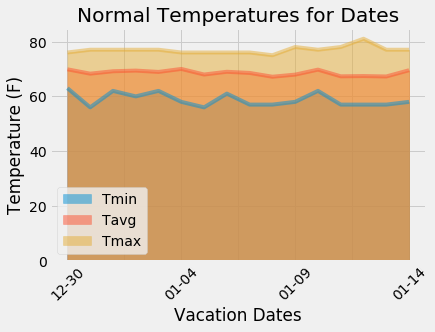

In [345]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xlabel('Vacation Dates')
plt.ylabel('Temperature (F)') 
plt.title('Normal Temperatures for Dates')
plt.xticks(rotation=45)
plt.savefig("Images output/Temperatures for Vacation Dates.png",bbox_inches='tight')
plt.show()
